# Disjunctive Job-Shop

$$
\begin{align}
    \text{min} \quad & C \\
    \text{s.t.} \quad & x_{\sigma_{h-1}^j, j} + p_{\sigma_{h-1}^j, j} \leq x_{\sigma_{h}^j, j}
        & \forall ~ j \in J; h \in (2, ..., |M|)\\
    & x_{m, j} + p_{m, j} \leq x_{m, k} + V (1 - z_{m, j, k})
        & \forall ~ j, k \in J, j \neq k; m \in M\\
    & z_{m, j, k} + z_{m, k, j} = 1
        & \forall ~ j, k \in J, j \neq k; m \in M\\
    & x_{\sigma_{|M|}^j, j} + p_{\sigma_{|M|}^j, j} \leq C
        & \forall ~ j \in J\\
    & x_{m, j} \geq 0 & \forall ~ j \in J; m \in M\\
    & z_{m, j, k} \in \{0, 1\} & \forall ~ j, k \in J; m \in M\\
\end{align}
$$"

In [1]:
import json
import os

import pyomo.environ as pyo
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
with open(os.path.join("data", "random_3_4.json"), mode="r") as file:
    data = json.load(file)

In [3]:
machines = sorted(data["technology"][0])
jobs = list(range(len(data["technology"])))
processing = {
    (record["machine"], record["job"]): record["time"]
    for record in data["processing"]
}
sequences = [
    (m1, row[h + 1], j)
    for j, row in enumerate(data["technology"])
    for h, m1 in enumerate(row[:-1])
]

## pyomo

In [4]:
model = pyo.ConcreteModel()

In [5]:
# Sets for machines, jobs, horizon, and job sequences
model.M = pyo.Set(initialize=machines)
model.J = pyo.Set(initialize=jobs)
model.E = pyo.Set(initialize=[(j, k) for j in jobs for k in jobs if j != k])
model.Sigma = pyo.Set(initialize=sequences)

In [6]:
# Parameters
model.p = pyo.Param(model.M, model.J, initialize=processing)
model.V = pyo.Param(initialize=sum(p for p in processing.values()))

In [7]:
# Variables
model.x = pyo.Var(model.M, model.J, within=pyo.NonNegativeReals)
model.z = pyo.Var(model.M, model.E, within=pyo.Binary)
model.C = pyo.Var(within=pyo.NonNegativeReals)

In [8]:
# Constraints
def cstr_seq(model, m1, m2, j):
    return model.x[m1, j] + model.p[m1, j] <= model.x[m2, j]


def cstr_precede(model, m, j, k):
    return model.x[m, j] + model.p[m, j] <= model.x[m, k] + model.V * (1 - model.z[m, j, k])


def cstr_comp_precede(model, m, j, k):
    return model.z[m, j, k] + model.z[m, k, j] == 1.0


def cstr_total_time(model, m, j):
    return model.x[m, j] + model.p[m, j] <= model.C

In [9]:
model.cstr_seq = pyo.Constraint(model.Sigma, rule=cstr_seq)
model.cstr_precede = pyo.Constraint(model.M, model.E, rule=cstr_precede)
model.cstr_comp_precede = pyo.Constraint(model.M, model.E, rule=cstr_comp_precede)
model.cstr_total_time = pyo.Constraint(model.M, model.J, rule=cstr_total_time)

In [10]:
# Objective
model.obj = pyo.Objective(expr=model.C, sense=pyo.minimize)

## Solve

In [11]:
solver = pyo.SolverFactory("appsi_highs")
solver.options["mip_heuristic_effort"] = 0.1
solver.options["time_limit"] = 120
solver.options["log_file"] = "Highs.log"
solver.solve(model, tee=True)

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
56 rows, 31 cols, 148 nonzeros
38 rows, 31 cols, 94 nonzeros
38 rows, 31 cols, 94 nonzeros

Solving MIP model with:
   38 rows
   31 cols (18 binary, 0 integer, 0 implied int., 13 continuous)
   94 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   46              inf                  inf        0      0      0         0     0.0s
 R       0       0         0   0.00%   46              145               68.28%        0      0      0        14     0.0s
 L       0       0         0   0.00%   50.39141991     52                 3.09%      290     45      0       116     0.0s

27.8% inactive integer columns, restarting
Model after

{'Problem': [{'Lower bound': 52.0, 'Upper bound': 52.0, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Sense': 1}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.optimal'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [12]:
def get_plot_elements(self, j):
    machines = [x.index()[0] for x in self.x[:, j]]
    starts = [x.value for x in self.x[:, j]]
    spans = [self.p[m, j] for m in machines]
    return machines, starts, spans


def plot_horizontal(model, figsize=[7, 3], dpi=100, colors=None):

    if colors is None:
         colors = mpl.colormaps["Dark2"].colors

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    for i, j in enumerate(model.J):
        machines, starts, spans = get_plot_elements(model, j)

        if i >= len(colors):
            i = i % len(colors)

        color = colors[i]
        ax.barh(machines, spans, left=starts, label=f"Job {j}", color=color)

    ax.set_yticks(model.M)
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1.03))
    fig.tight_layout()
    plt.show()

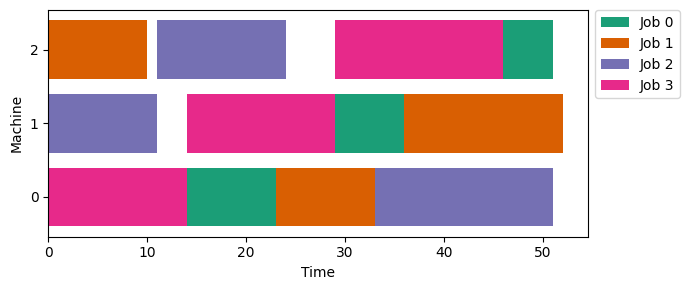

In [13]:
plot_horizontal(model)